# Курс орнитологии

1. Реализуйте модель для извлечения признаков из голоса птиц. За основу можно брать:
   - преобразование в аудиофичи (например как mfcc в лекции. Конкретно это преобразование использовать нельзя)
   - обученные поверх аудиофич ML модели
  
1. С помощью модели и одного из предложенных датасетов создайте эмбеддинги пения птиц. Создайте эмбеддинги нескольких записей каждого вида птиц. Визуализируйте эмбеддинги. Для визуализации рекомендуется использовать подмножество видов птиц

1. Аргументируйте почему ваша модель хорошо извлекает признаки из аудио. 
    - Покажите кластеризацию эмбеддингов по видам

1. С помощью эмбеддингов найдите похожие по звучанию виды птиц. Выведите примеры их пения в ноутбуке.



Датасеты:
1. [Датасет](https://www.kaggle.com/vinayshanbhag/bird-song-data-set) американских птиц
1. Почищенный от фонового шума BirdCall [датасет](https://www.kaggle.com/luisblanche/birdcall-singing-3)
1. [Датасет](https://www.kaggle.com/luisblanche/birdcall-singing-0) BirdCall часть 1

In [1]:
import torchaudio
import torch
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

%matplotlib inline

In [2]:
%%time
import os
from pathlib import Path
path = Path('./archive')
speechs = {}
for category in os.listdir(path):
    catPath = path / category
    lst = []
    speechs[category] = lst
    # filename = os.listdir(catPath)[0]
    
    print(f'loading {category}')
    i = 0
    for file in os.listdir(catPath):
        if i % 10 == 0:
            print(f'\t{file}')
        i += 1
        if i > 30:
            break

        lst.append(librosa.load(catPath / file, duration=8))

loading norcar
	XC109034.wav
	XC143802.wav
	XC177125.wav
	XC205824.wav
loading norfli
	XC104536.wav
	XC139906.wav
	XC170551.wav
	XC184200.wav
loading norhar2
	XC121401.wav
	XC277504.wav
	XC329772.wav
loading normoc
	XC111150.wav
	XC172647.wav
	XC202601.wav
	XC312453.wav
loading norpar
	XC101589.wav
	XC137550.wav
	XC169227.wav
	XC173777.wav
loading norpin
	XC113161.wav
	XC182407.wav
	XC302656.wav
	XC452637.wav
loading norsho
	XC110104.wav
	XC161636.wav
	XC301021.wav
	XC368560.wav
loading norwat
	XC120620.wav
	XC150069.wav
	XC182058.wav
	XC193157.wav
loading nrwswa
	XC123367.wav
	XC239857.wav
	XC379022.wav
loading nutwoo
	XC109667.wav
	XC161357.wav
	XC301366.wav
	XC450920.wav
loading olsfly
	XC113836.wav
	XC132932.wav
	XC207797.wav
	XC249357.wav
loading orcwar
	XC113131.wav
	XC169232.wav
	XC195051.wav
	XC225461.wav
loading osprey
	XC109037.wav
	XC134750.wav
	XC167214.wav
	XC190478.wav
loading ovenbi1
	XC118066.wav
	XC140260.wav
	XC149483.wav
	XC149495.wav
loading palwar
	XC111161.wav
	XC

## LFCC не MFCC

птички не люди...

In [3]:
# название mel чтобы зап
mel_transform = torchaudio.transforms.LFCC()
mel_transform

LFCC(
  (amplitude_to_DB): AmplitudeToDB()
  (Spectrogram): Spectrogram()
)

In [4]:
%%time
def make_mels(audio: torch.Tensor) -> torch.Tensor:
    mels = mel_transform(audio)
    mels = mels.mean(dim=1)
    return mels

mels = {}
for k, v in speechs.items():
    mels[k] = [make_mels(torch.Tensor(audio[0])) for audio in v]

Wall time: 6.64 s


In [5]:
melsFlat = []
targets = []
for k, vlst in mels.items():
    melsFlat += vlst
    targets += [k] * len(vlst)

In [6]:
import umap

In [7]:
def makeColorsFrom(it):
    colorsMap = {}
    cmap = plt.cm.rainbow
    i = 0
    l = len(it)
    for k in it:
        colorsMap[k] = cmap((i + 1) / l)
        i += 1
    return colorsMap
def makeColorsFor(it, ys):
    m = makeColorsFrom(it)
    return [m[i] for i in ys]

In [8]:
stackedMels = torch.stack(melsFlat)
embs = umap.UMAP().fit_transform(stackedMels)

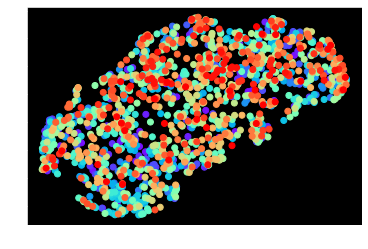

In [9]:
plt.scatter(embs[:, 0], embs[:, 1], color=makeColorsFor(mels, targets))
plt.show()

## KMeans

In [10]:
from sklearn.cluster import KMeans

In [11]:
clusters = KMeans(n_clusters=len(speechs), random_state=30).fit(stackedMels)

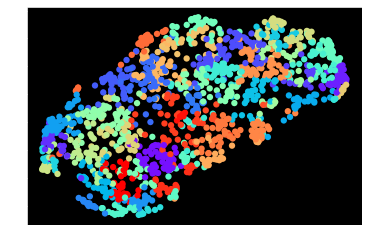

In [12]:
plt.scatter ( embs[:, 0]
            , embs[:, 1]
            , edgecolor='none'
            , alpha=1
            , s=40
            , color=makeColorsFor(range(len(set(clusters.labels_))), clusters.labels_)
            )
plt.show()

## Датасет 😋

In [13]:
import IPython
from IPython.display import Markdown

In [14]:
IPython.display.display(Markdown('тут вообще есть звуки?'))
IPython.display.Audio(path / 'rocpig/XC347881.wav')

тут вообще есть звуки?

In [15]:
IPython.display.display(Markdown('2 птицы'))
IPython.display.Audio(path / 'rocpig/XC113783.wav')

2 птицы

In [26]:
IPython.display.display(Markdown('кто-то разговаривает, собаки лают'))
IPython.display.Audio(path / 'rocpig/XC266224.wav')

кто-то разговаривает, собаки лают

## Критичен ли ресемплинг?

In [17]:
IPython.display.Audio(path / 'norcar/XC109034.wav')

In [18]:
wave, rate = librosa.load(path / 'norcar/XC109034.wav')
IPython.display.Audio(librosa.resample(wave, rate, 16000), rate=16000)

## Word2Vec

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
from transformers import Wav2Vec2Model
from transformers import Wav2Vec2Config
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from tqdm.notebook import tqdm_notebook

In [22]:
%%time
withWord2Vec = []
with torch.no_grad():
    for v in tqdm_notebook(speechs.values()):
        for i in v:
            wave = librosa.resample(i[0], i[1], 16000)
            input_values = processor(wave, return_tensors='pt', sampling_rate=16000).input_values.to(device)
            withWord2Vec.append(model.forward(input_values).last_hidden_state[0])

  0%|          | 0/51 [00:00<?, ?it/s]

Wall time: 37min 45s


In [23]:
embsW2V = [x.mean(dim=0) for x in withWord2Vec]

In [24]:
stackedW2V = torch.stack(embsW2V)
embsW2V = umap.UMAP().fit_transform(stackedW2V)

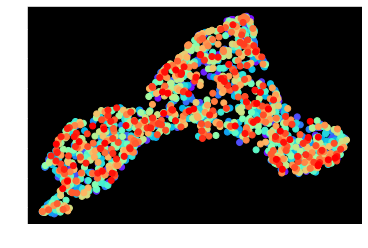

In [25]:
plt.scatter(embsW2V[:, 0], embsW2V[:, 1], color=makeColorsFor(mels, targets))
plt.show()

In [27]:
import numpy as np

In [28]:
flatSpeechs = []
for v in speechs.values():
    flatSpeechs += v

In [43]:
bird0 = embsW2V[0]
bestDist = np.linalg.norm(embsW2V[1] - bird0)
bestI = 1
worstDist = bestDist
worstI = bestI
for i in range(2, len(embsW2V)):
    if targets[i] == targets[0]:
        continue
    nd = np.linalg.norm(embsW2V[i] - bird0)
    if nd < bestDist:
        bestDist = nd
        bestI = i
    if nd > worstDist:
        worstDist = nd
        worstI = i

In [48]:
IPython.display.display(Markdown(f'* {bestDist}\n* {worstDist}'))

* 0.10762836784124374
* 11.021804809570312

In [45]:
IPython.display.display(Markdown(targets[0]))
IPython.display.Audio(flatSpeechs[0][0], rate=flatSpeechs[0][1])

norcar

In [46]:
IPython.display.display(Markdown(targets[bestI]))
IPython.display.Audio(flatSpeechs[bestI][0], rate=flatSpeechs[bestI][1])

reevir1

In [47]:
IPython.display.display(Markdown(targets[worstI]))
IPython.display.Audio(flatSpeechs[worstI][0], rate=flatSpeechs[worstI][1])

nutwoo